# Data Cleaning Methodology

## Census API Data Pull

In [1]:
# Import Libraries for API Key
from census import Census
from us import states
import csv
import time
import pdb
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.style
from geopy.geocoders import Nominatim
import time
import numpy as np
import json

# Initialize Census object with API key to utilize census python wrapper to pull data
c = Census("a843158c55ae161d6ec8bfe7530da4c8e5acebbc")

In [2]:
# Set Precision
pd.set_option("precision", 2)

In [3]:
# See available matplotlib styles
matplotlib.style.use('fivethirtyeight')

In [176]:
c.acs5.tables()

[{'name': 'B17015',
  'description': 'POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY SOCIAL SECURITY INCOME BY SUPPLEMENTAL SECURITY INCOME (SSI) AND CASH PUBLIC ASSISTANCE INCOME',
  'variables': 'https://api.census.gov/data/2018/acs/acs5/groups/B17015.json'},
 {'name': 'B18104',
  'description': 'SEX BY AGE BY COGNITIVE DIFFICULTY',
  'variables': 'https://api.census.gov/data/2018/acs/acs5/groups/B18104.json'},
 {'name': 'B17016',
  'description': 'POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY WORK EXPERIENCE OF HOUSEHOLDER AND SPOUSE',
  'variables': 'https://api.census.gov/data/2018/acs/acs5/groups/B17016.json'},
 {'name': 'B18105',
  'description': 'SEX BY AGE BY AMBULATORY DIFFICULTY',
  'variables': 'https://api.census.gov/data/2018/acs/acs5/groups/B18105.json'},
 {'name': 'B17017',
  'description': 'POVERTY STATUS IN THE PAST 12 MONTHS BY HOUSEHOLD TYPE BY AGE OF HOUSEHOLDER',
  'variables': 'https://api.census.gov/data/2018/acs/acs5/gro

The below is an example of a dictionary we will build out that will contain all of the tables
we intend to make request to in the census api. We will leverage the **sub-group** as the key (i.e. B17015_038E) and **description** as the value. Overall, we intend to make request for each of these categories and likely more as the project develops:
- unemployment rate
- Poverty Rate
- Median Household Income rate
- Educational Attainment
- Race/demographics
- Geo-location
- AT HOME FOR THE POPULATION 25 YEARS AND OVER
- Per capita income

In [4]:
# Key is an example of the name that needs to be passed in to get data
tables_dict = {
    'B17015_038E': "POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY FAMILY TYPE BY SOCIAL SECURITY INCOME BY SUPPLEMENTAL SECURITY INCOME (SSI) AND CASH PUBLIC ASSISTANCE INCOME",
    'B23025_004E': "Estimate!!Total!!In labor force!!Civilian labor force!!Employed",
    'B23025_005E': "Estimate!!Total!!In labor force!!Civilian labor force!!Unemployed",
    'B23025_003E': "Estimate!!Total!!In labor force!!Civilian labor force",
    "B23025_002E": "Estimate!!Total!!In labor force",
    "B23025_007E": "Estimate!!Total!!Not in labor force",
    "B19301E_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301A_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301D_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301C_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301B_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301H_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301I_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301G_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19301F_001E": "Estimate!!Per capita income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19013_001E": "Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars)",
    "B19019_001E": "MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) BY HOUSEHOLD SIZE",
    "B19058_001E": "PRECEIPT OF FOOD STAMPS/SNAP IN THE PAST 12 MONTHS BY POVERTY STATUS IN THE PAST 12 MONTHS FOR HOUSEHOLDS",
    "B22003_001E": "PUBLIC ASSISTANCE INCOME OR FOOD STAMPS/SNAP IN THE PAST 12 MONTHS FOR HOUSEHOLDS",
    "B19113C_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER)",
    "B19113D_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (ASIAN ALONE HOUSEHOLDER)",
    "B19113A_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE HOUSEHOLDER)",
    "B19113B_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)",
    "B19113G_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (TWO OR MORE RACES)",
    "B19113H_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE NOT HISPANIC OR LATINO HOUSEHOLDER))",
    "B19113E_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE HOUSEHOLDER)",
    "B19113F_001E": "MEDIAN FAMILY INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (SOME OTHER RACE ALONE HOUSEHOLDER)",
    "B19013_001E": "MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)",
    "B99191_001E": "ALLOCATION OF INDIVIDUALS' INCOME IN THE PAST 12 MONTHS FOR THE POPULATION 15 YEARS AND OVER - PERCENT OF INCOME ALLOCATED",
    "B19202F_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (SOME OTHER RACE ALONE HOUSEHOLDER)",
    "B19202G_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (TWO OR MORE RACES HOUSEHOLDER)",
    "B19202H_001E": "|MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (WHITE ALONE NOT HISPANIC OR LATINO HOUSEHOLDER)|",
    # No good for us
    "B19050_001E": "AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) BY AGE OF HOUSEHOLDER",
    "B19202I_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (HISPANIC OR LATINO HOUSEHOLDER)",
    "B19202B_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (BLACK OR AFRICAN AMERICAN ALONE HOUSEHOLDER)",
    "B19202C_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (AMERICAN INDIAN AND ALASKA NATIVE ALONE HOUSEHOLDER)",
    "B19202D_001E": "MEDIAN NONFAMILY HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS) (ASIAN ALONE HOUSEHOLDER)",
    "B15001_001E": "SEX BY AGE BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 18 YEARS AND OVER",
    "B01002_001E": "MEDIAN AGE BY SEX",
    "B23025_001E": "EMPLOYMENT STATUS FOR THE POPULATION 16 YEARS AND OVER",
    "B19301_001E": "PER CAPITA INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)",
    "B01002G_001E": "MEDIAN AGE BY SEX (TWO OR MORE RACES)",
    "B01002H_001E": "|MEDIAN AGE BY SEX (WHITE ALONE NOT HISPANIC OR LATINO)",
    "B01002I_001E": "MEDIAN AGE BY SEX (HISPANIC OR LATINO)",
    "B01002C_001E": "MEDIAN AGE BY SEX (AMERICAN INDIAN AND ALASKA NATIVE ALONE)",
    "B01002D_001E": "MEDIAN AGE BY SEX (ASIAN ALONE)",
    "B01002E_001E": "MEDIAN AGE BY SEX (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)",
    "B01002F_001E": "HMEDIAN AGE BY SEX (SOME OTHER RACE ALONE)",
    "B01002A_001E": "MEDIAN AGE BY SEX (WHITE ALONE)",
    "B01002B_001E": "MEDIAN AGE BY SEX (BLACK OR AFRICAN AMERICAN ALONE)",

}

The below cell iterates through each key in our `tables_dict`. We will use the key as the name of the csv, referncing the `tables_dict` to remember the data we are using. 

For each key we iterate through, we will be iterating through the years for the ACS5 dataset, which is:

> The 5-year estimates from the ACS are "period" estimates that represent data collected over a period of time.

For each year, we will:
1. Make a get request `c.acs5.state_county` at the state-county level for the specified sub-group (i.e. B17015_038E)
2. We will index into the first object in the response to leverage as out columns
3. Finally, we will iterate through each state-county response and write them to the file

In [21]:
# Years we want to collect. The census api already has this attribute, so we don't errneously
# pull years not available
years = c.acs5.years

for key in tables_dict.keys():
    try:
        path = os.path.join(os.getcwd(), key[:6])
        if not os.path.exists(path):
            os.mkdir(path)
        with open(f'{path}/{key}.csv', 'w', newline='') as csvfile:
            spamwriter = csv.writer(csvfile)
            
            # Iterate through years
            for idx, year in enumerate(years):
                # Fetch data
                response = c.acs5.state_county(('NAME', key), Census.ALL, Census.ALL, year=year)
                
                # Check if this is the first index so we don't re-write headers each time.
                if idx == 0:
                    # Collect columns and write them as the header
                    columns = list(response[0].keys()) + ['year']
                    spamwriter.writerow(columns)
                
                # Iterate through each nested response and write them to the csv
                for row in response:
                    #pdb.set_trace()
                    spamwriter.writerow([row[name] for name in list(response[0].keys())] + [year])
                
                # Delay script every 30 secs so that we don't get flagged for request abuse
                time.sleep(10)
    except:
        continue

Once all of the data has been collected, we will do some data cleaning. Example of this is shown below, splitting the *state* and *county* from the **NAME** column and placing them into their respective columns.

In addition to the above, we intend to:
- Aggregate *geo-location* and other elements to the tables we create.
- Assess `Null`/`0` values to see if we want to retain them

In [3]:
for subdir, dirs, files in os.walk('files/'):
    if len(dirs) > 0:
        for d in dirs:
            p = os.path.join('files/', d)
            temp_list = []
            for file in os.listdir(p):
                if file.endswith('.csv'):
                    temp_list.append(pd.read_csv(p + '/' + file))
            print(d)
            if d[0] == "B":
                df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['NAME', 'state', 'county', 'year'],
                                                how='left'), temp_list)

                df_merged.to_csv(f'files/{d}_merged.csv', index=False)
            else:
                df_merged = pd.concat(temp_list)
                df_merged.to_csv(f'files/{d}_merged.csv', index=False)


                


whole_foods
B19113
B19050
bk_docs
B15001
B19058
B22003
ctown_docs
trader
B19019
aldi_docs
B23025
wendys
B17015
B99191
B01002
B19202
B19013
B19301


### Move files

In [4]:
for file in os.listdir('files/'):
    if file.endswith('merged.csv'):
        os.rename(os.path.join('files/', file), os.path.join('merged_files/', file))

### Clean Data

In [49]:
# Split and pass into columns
def county_state_split(df):
    df['county'] = df['NAME'].str.split(',').str[0]
    df['state'] = df['NAME'].str.split(',').str[1]
    df.drop('NAME', inplace=True, axis=1)
    return df

In [ ]:
# Replace negative values with 0s. Reqiures investigation
for data in os.listdir('merged_files/'):
    if data.startswith('B'):
        df = pd.read_csv(f'merged_files/{data}')
        df.replace(-666666666.0, 0, inplace=True)
        df.to_csv(f'merged_files/{data}',index=False)

### Describe Data

In [19]:
# General Summary Stats of census tables
for data in os.listdir('merged_files/'):
    if data.startswith('B'):
        df = pd.read_csv(f'merged_files/{data}')
        print('\n \n')
        print(f"Table Describtion for: {data} \n")
        print(df.describe())
        print('\n \n')



 

Table Describtion for: B01002_merged.csv 

       B01002E_001E         state        county          year  B01002D_001E  \
count  29909.000000  32205.000000  32205.000000  32205.000000  31603.000000   
mean       9.694192     31.293743    103.008943   2013.499612     29.936974   
std       16.407685     16.275521    106.815913      2.872326     17.397051   
min        0.000000      1.000000      1.000000   2009.000000      0.000000   
25%        0.000000     19.000000     35.000000   2011.000000     22.300000   
50%        0.000000     30.000000     79.000000   2013.000000     32.900000   
75%       20.400000     46.000000    133.000000   2016.000000     39.700000   
max       95.200000     72.000000    840.000000   2018.000000     95.400000   

       B01002H_001E  B01002I_001E  B01002B_001E  B01002C_001E  B01002F_001E  \
count  32202.000000  32129.000000   9660.000000  31713.000000  31785.000000   
mean      43.651332     25.874565     31.619234     32.019503     25.584106   
std 


 

Table Distribution for: B01002_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B23025_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B17015_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B99191_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B19202_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B19013_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B19113_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B19301_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B19058_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B15001_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distribution for: B22003_merged.csv 

AxesSubplot(0.125,0.125;0.775x0.755)

 


 

Table Distributio

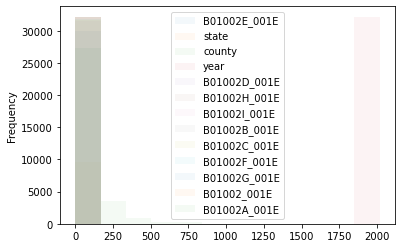

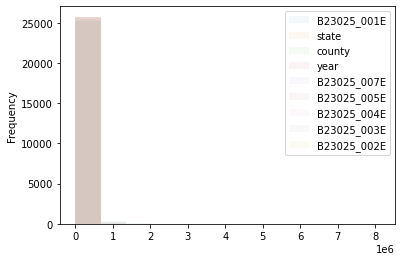

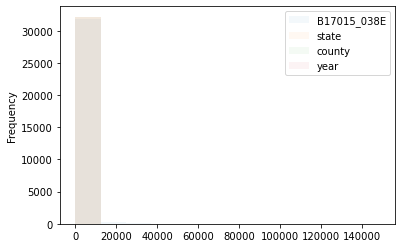

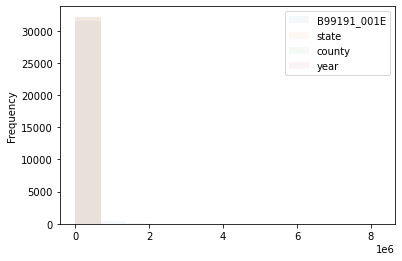

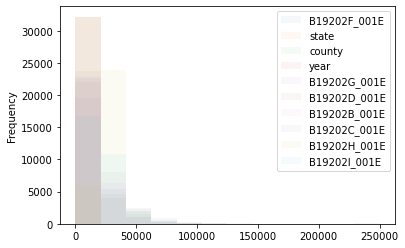

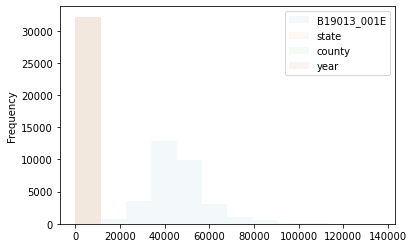

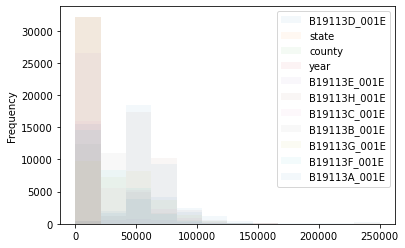

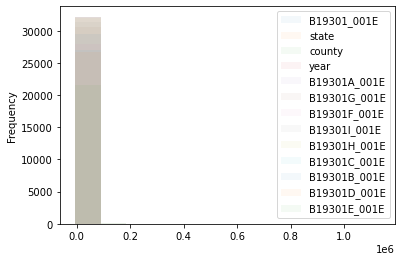

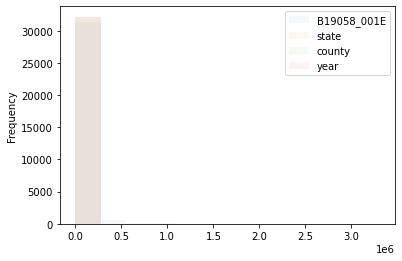

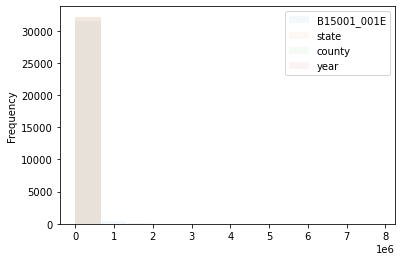

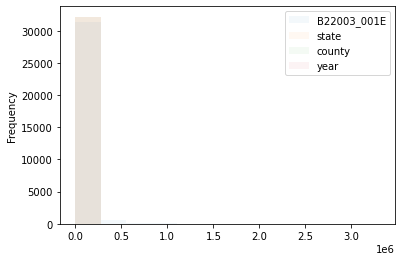

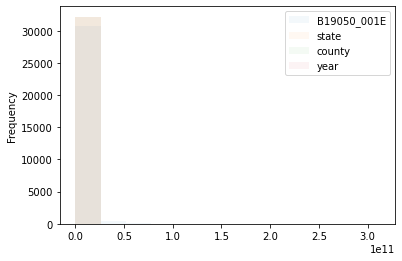

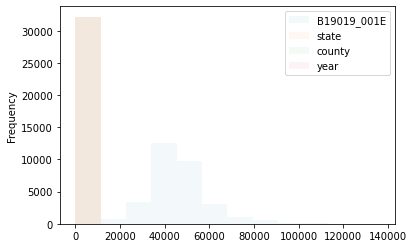

In [4]:
# Distributions of Census tables
for data in os.listdir('merged_files/'):
    if data.startswith('B'):
        df = pd.read_csv(f'merged_files/{data}')
        print('\n \n')
        print(f"Table Distributions for: {data} \n")
        print(df.plot.hist(bins=12, alpha=.05))
        print('\n \n')


In [20]:
df.head()

,B17015_038E,state,county,year
0,497.0,Mississippi,Washington County,2018
1,124.0,Mississippi,Perry County,2018
2,46.0,Mississippi,Choctaw County,2018
3,212.0,Mississippi,Itawamba County,2018
4,41.0,Mississippi,Carroll County,2018


In [5]:
# Look at burker kings by location
df = pd.read_csv(f'merged_files/bk_docs_merged.csv')

<AxesSubplot:xlabel='City'>

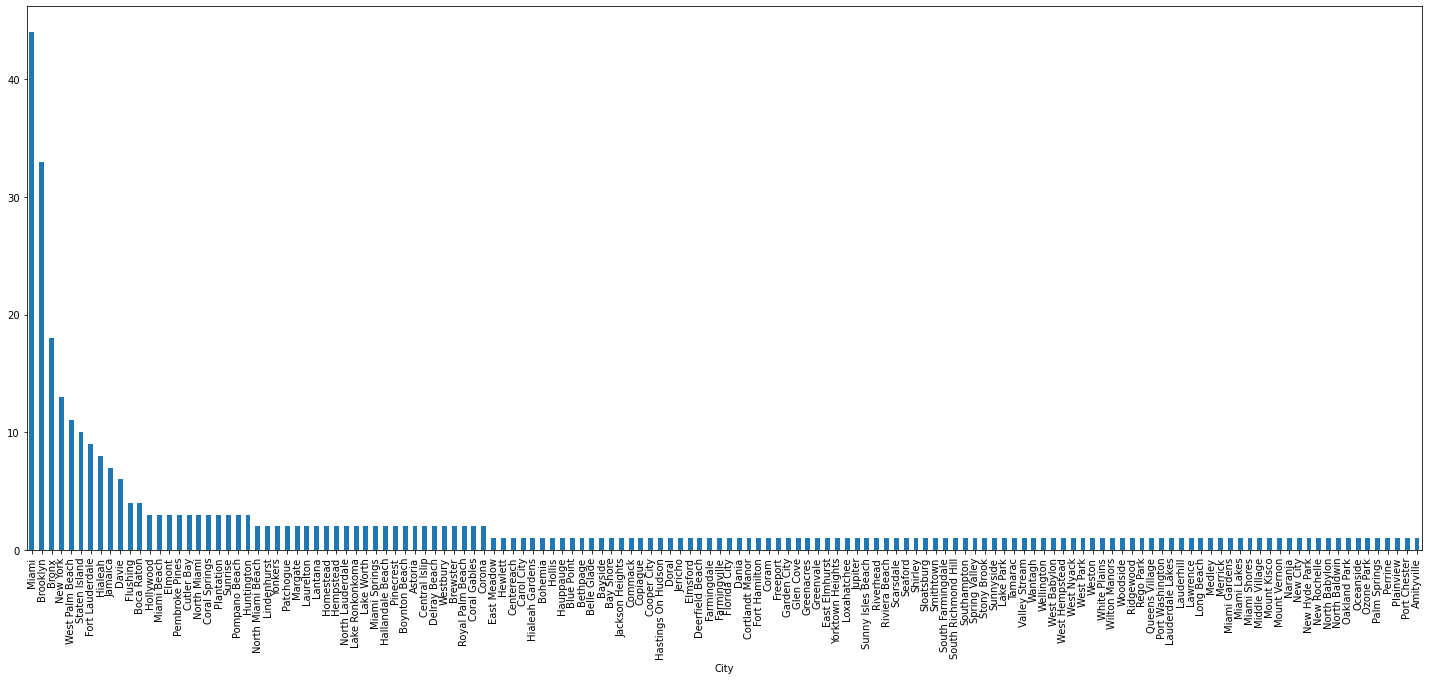

In [43]:
# Look at burker kings by location
df = pd.read_csv(f'merged_files/bk_docs_merged.csv')
plt.figure(figsize=(25,10))
df.groupby('City')['ZIP Code'].count().sort_values(ascending=False).plot.bar()

<AxesSubplot:xlabel='City'>

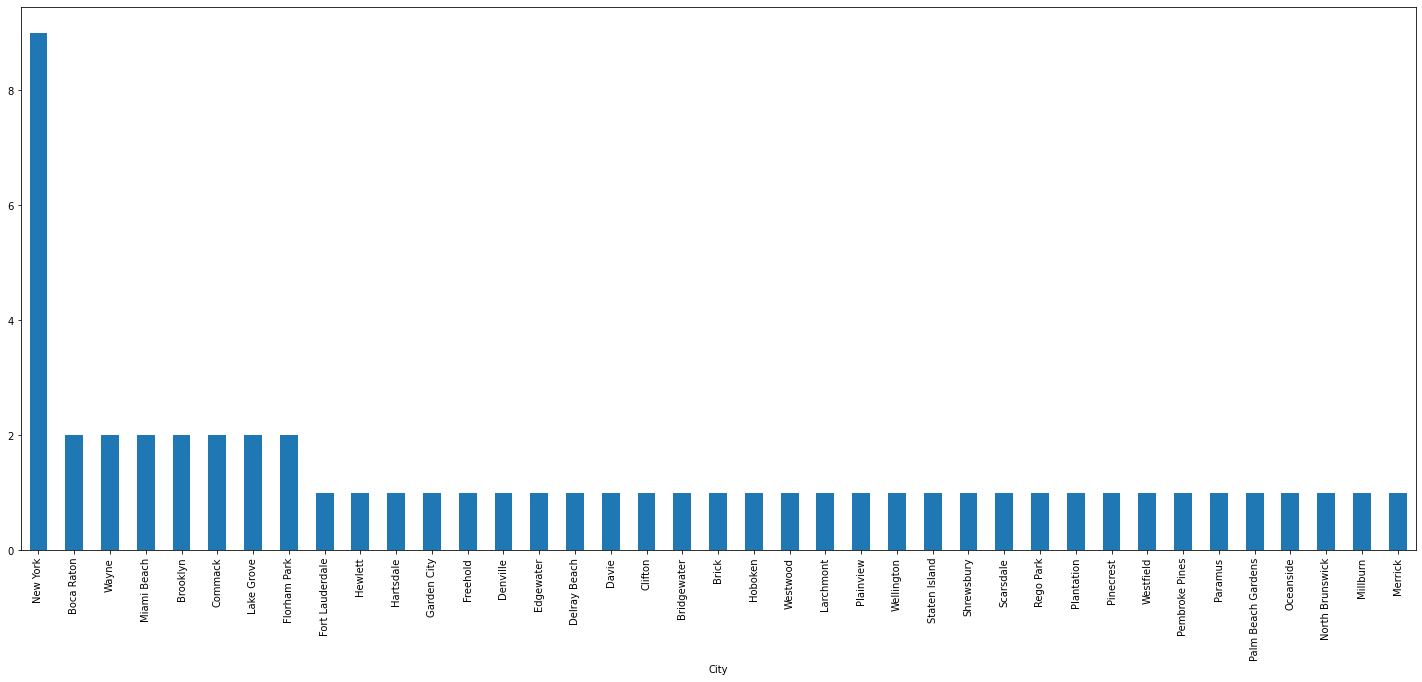

In [44]:
# Look at burker kings by location
df = pd.read_csv(f'merged_files/trader_merged.csv')
plt.figure(figsize=(25,10))
df.groupby('City')['ZIP Code'].count().sort_values(ascending=False).plot.bar()

# Clean Population Data

In [142]:
# Fix Population Data
pop_df = pd.read_csv('merged_files/PopulationEstimates.csv', encoding = "ISO-8859-1")

In [156]:
pop_df.drop(index=0, inplace=True)
pop_df['State_name'] = pop_df['State'].apply(lambda x: states.lookup(x).name if x else np.nan)

In [159]:
pop_df = pop_df.loc[:, ['State_name', 'Area_Name'] + 
                    [f'POP_ESTIMATE_20{y}' for y in range(10, 20) ]]

In [160]:
pop_df.rename(columns={
    "State_name" : "state",
    "Area_Name" : "county",  
}, inplace=True)

In [169]:
pop_df.columns = ['state', 'county'] + ["".join(i.split('_')[-1]) for i in pop_df.columns[2:]]

In [173]:
pop_df = pd.melt(pop_df, 
        id_vars=['state', 'county'], 
        value_vars=[str(i) for i in range(2010,2020)], 
        var_name='year', 
        value_name= 'population')

In [174]:
pop_df.to_csv('merged_files/PopulationEstimates(Cleaned).csv', index=False)

# Get Geolocation

In [84]:
food_list = ['bk', 'aldi', 'whole', 'trader', 'wendys', 'ctown']

In [5]:
# Initialize geopy
app = Nominatim(user_agent="tutorial")

In [ ]:
# Create Jsons for food/supermarkets
def create_json(file):
    print(file)
    df = pd.read_csv(f'merged_files/{file}')

    lat = []
    lon = []
    for idx, row in df.iterrows():
        print(row['ZIP Code'])
        try:
            location = app.geocode(row['ZIP Code']).raw
            lat.append(location['lat'])
            lon.append(location['lon'])
        except:
            print('Didnt work for', row['ZIP Code'])
            lat.append(np.nan)
            lon.append(np.nan)
        time.sleep(1)
    print('Done')
    df['lat_long'] = [list(i) for i in list(zip(lat, lon))]
    print("pre name split")
    name = "".join(file.split('.csv'))
    print(f"Loading {file}")
    df.loc[:, ['Company Name', 'lat_long']].to_json(f'{name}.json', orient='table')

In [89]:
for file in os.listdir('merged_files/'):
    if file.split('_')[0] in food_list:
        create_json(file)

wendys_merged.csv
33430
33428
33431
33431
33432
33434
33435
33426
33437
33328
33065
33071
33067
33067
33157
33314
33328
33314
33442
33441
33446
33444
11001
11354
11354
11377
11010
11530
11530
11542
11548
11788
11788
10532
11801
11742
11743
11746
11558
11751
11372
11435
11430
11432
11430
11753
11755
11234
11214
11207
11208
11209
11225
11203
11236
11236
10512
11934
11720
11725
11726
11726
10567
11554
11731
11518
11003
10523
10523
11735
11735
11735
11783
11784
11967
11780
10305
10303
10312
10314
10301
10309
11791
10983
11581
11793
11704
10993
11552
10994
11596
10710
33445
33178
33172
33166
33034
33304
33306
33312
33312
33309
33312
33309
33315
33467
33413
33009
33012
33016
33014
33013
33010
33015
33018
33024
33020
33064
33062
33060
33073
33069
33069
33069
33404
33411
33323
33326
33322
33351
33172
33321
33351
33409
33406
33407
33411
33405
33401
33326
33311
33157
33144
33147
33165
33174
33122
33056
33055
33014
33025
33027
33023
33068
33181
33168
33162
33408
33334
33410
33461
33021
33027
3302

In [95]:
json.load(open('wendys_merged.json'))['data']

[{'index': 0,
  'Company Name': "Wendy's",
  'lat_long': ['61.534683549617036', '23.603983918808147']},
 {'index': 1,
  'Company Name': "Wendy's",
  'lat_long': ['51.963357565220875', '8.229344843060668']},
 {'index': 2,
  'Company Name': "Wendy's",
  'lat_long': ['26.379418805418375', '-80.09764097487374']},
 {'index': 3,
  'Company Name': "Wendy's",
  'lat_long': ['26.379418805418375', '-80.09764097487374']},
 {'index': 4,
  'Company Name': "Wendy's",
  'lat_long': ['57.28159524365158', '13.645872643754414']},
 {'index': 5,
  'Company Name': "Wendy's",
  'lat_long': ['26.3827329278027', '-80.16684664696682']},
 {'index': 6,
  'Company Name': "Wendy's",
  'lat_long': ['26.526506638181104', '-80.06484924097595']},
 {'index': 7,
  'Company Name': "Wendy's",
  'lat_long': ['26.531495007062325', '-80.08339379126781']},
 {'index': 8,
  'Company Name': "Wendy's",
  'lat_long': ['26.524621882484702', '-80.15171198567771']},
 {'index': 9,
  'Company Name': "Wendy's",
  'lat_long': ['26.065968

In [91]:
print(os.listdir())

['EDA.ipynb', 'census.ipynb', 'aldi_docs_merged.json', '.DS_Store', 'test.js', 'trader_merged.json', 'bk_docs_merged.json', 'wendys_merged.json', 'Detail Sprouts Farmers FL.csv', 'B17015_038E.csv', 'Detail Westside NY.csv', 'whole_foods_merged.json', 'README.md', 'ctown_docs_merged.json', 'TeamNumber_Project_Week7.ipynb', '.gitignore', 'flask_app', 'merged_files', 'files', 'templates', 'bk_lat-lon.json', '.ipynb_checkpoints', '.git', 'Detail Westside FL.csv', 'Detail Wegmans Food Markets NY Only.csv']


# Demographics + Population + Income

In [ ]:
# Intialize Demographics dataframe list
dem_dataframes = []

#Create Demographics Census Dictionary
dem_tables = {
    'C02003_003E': 'White',
    'C02003_004E': 'Black',
    'C02003_005E': 'American_Indian',
    'C02003_006E': 'Asian',
    'C02003_007E': 'Native_Hawaian',
    'C02003_008E': 'Other-one',
    'C02003_013E': 'White-Black',
    'C02003_014E': 'White-AI',
    'C02003_015E': 'White-Asian',
    'C02003_016E': 'Black-AI',
    'C02003_017E': 'Other-two',
    'C02003_018E': 'Three',
    'C02003_019E': 'Four',
}

# Pull Demogra[phics Data
years = c.acs5.years
for k, v in dem_tables.items():
    tmp_dfList = []
    for y in years:
        try:
            results = c.acs5.state_county(('NAME', k), Census.ALL, Census.ALL, year=y)
            df = pd.DataFrame(data =[i.values() for i in results], columns = results[0].keys()).assign(
                    year = y
                ).rename(columns={k: v})
            tmp_dfList.append(df)
            time.sleep(1)
        except:
            pass
    dem_dataframes.append(pd.concat(tmp_dfList))
    
#Merge all demographics to one table
from functools import reduce
df_merged = reduce (lambda left, right: pd.merge(left, right, on=['NAME', 'state', 'county', 'year'], how='outer'), dem_dataframes)
df_merged = county_state_split(df_merged)
df_merged['state'] = df_merged['state'].str.strip()

#df_merged.to_csv('merged_files/demographics.csv', index=False)

#Read in population data previously cleaned
pop_df = pd.read_csv('merged_files/PopulationEstimates(Cleaned).csv')
pop_df = pop_df[pop_df['year'] != 2019]

# Read in Median Household income
income = pd.read_csv('merged_files/B19019_merged.csv')
income = county_state_split(income)
income.dropna(subset=['state'], inplace=True) # removes states that are NA
income = income[income['state'] != ' Puerto Rico']
income['state'] = income['state'].str.strip()

# Merge them all
pop_dem = pd.merge(pop_df, df_merged, on=['state', 'county', 'year'], how='left')
pop_dem_income = pd.merge(pop_dem, income, on=['state', 'county', 'year'], how='left')
pop_dem_income.rename({'B19019_001E': "median_HH_Income"}, inplace=True)

# Save
pop_dem_income.to_csv('merged_files/Pop-Demo-Income.csv', index=False)